The first differential equation to be solved implicitly is the two-dimensional wave equation $\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = 0$. The __Grid__ is defined, which will contain the numerical values for $u$ in the domain, and also the __TimeFunction__, which is the symbolic representation of the variable $u$ inside Devito.

In [8]:
from devito import Grid, TimeFunction

shape = (50, 50)   # Grid size in number of points
extent = (1., 1.)  # Grid size in meters

grid = Grid(shape = shape, extent = extent) # The spatial grid matrix
u = TimeFunction(name = 'u', grid = grid) # The symbolic representation of the wave function

Then the parameters for the PDE are defined. The parameter $\lambda = \frac{dt}{dx}$ must be chosen such that the numerical scheme used afterwards is stable. It is sufficient to choose $|max(c, v) \cdot \lambda| \leq 1$, respecting the CFL condition. Also note that the value of the velocity $c$ in the $x$ direction is 10 times less than the velocity $v$ in the $y$ direction.

In [9]:
c, v = 0.1, 1      # Velocities for the waves
Lambda = 0.2       # Lambda = dt / dx = dt / dy

dx = extent[0] / (shape[0] - 1) # The spatial step in the x direction
dy = extent[1] / (shape[1] - 1) # The spatial step in the y direction
dt = Lambda * dx                # The time step

tf = 0.1            # The final time is 0.1 seconds
time = int(tf / dt) # The number of steps necessary to reach the final time

Next, the initial condition is applied to the grid data and plotted. The initial condition is chosen to be zero at almost all the domain, except for a square that fills the central part of the domain, as can be seen after the execution of the code below.

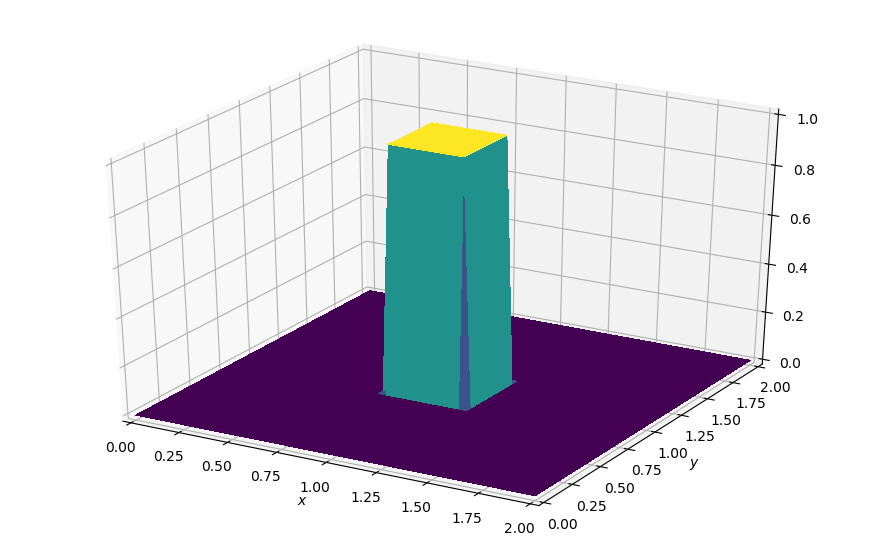

In [10]:
import numpy as np

def u0(u): # Define the initial condition for 'u'
    tempx, tempy = int(0.2 * shape[0]), int(0.2 * shape[1])

    u.data[0][2*tempx:3*tempx, 2*tempy:3*tempy] = 1
    u.data[1] = u.data[0]
    
from examples.cfd import plot_field

u0(u)                 # Apply the initial condition
plot_field(u.data[0]) # Plot the initial condition

Finally, the PDE can be declared. Since the velocity $v$ is 10 times bigger than the velocity $c$, it makes sense to use an implicit method to handle the $y$ direction. Suppose we have a differential equation $\frac{\partial u}{\partial t} = A(u) + B(u)$, where $A(u)$ represent stiff terms, which must be handled implicitly, and $B(u)$ are nonstiff, which can be handled explicitly. Using the combined forward euler and backward euler, the final equation becomes $\frac{\partial u}{\partial t} = A(u(t+\Delta t)) + B(u(t))$. In this example, $A(u) = v \frac{\partial u}{\partial y}$ and $B(u) = c \frac{\partial u}{\partial x}$. Notice that the discretization used below is backward in space ("dxl", "dyl") and forward in time ("dtr").

In [11]:
from devito import Eq

pde = Eq(u.dtr + c*u.dxl + v*u.forward.dyl) # The two-dimensional wave equation

print(str(pde.evaluate.lhs) + " = 0")

u(t + dt, x, y)/h_y - u(t + dt, x, y - h_y)/h_y + 0.1*u(t, x, y)/h_x - 0.1*u(t, x - h_x, y)/h_x - u(t, x, y)/dt + u(t + dt, x, y)/dt = 0


As you can see, there is more than one term in the discretized equation which is forward in time, namely "u(t + dt, x, y)/h_y" and "- u(t + dt, x, y - h_y)/h_y". Since these terms are directly dependent on the discretization and the implicit-explicit method chosen, the solver requires them to be isolated from the other terms. In other words, these terms must be "collected" to the left side of the equation so they can be analyzed by the implicit solver.

In [12]:
from devito import collect_forward

stencil = collect_forward(pde) # Collect the terms forward in time to the left side of the equation

print(str(stencil.lhs) + " = " + str(stencil.rhs))

(1/h_y + 1/dt)*u(t + dt, x, y) - u(t + dt, x, y - h_y)/h_y = -0.1*u(t, x, y)/h_x + 0.1*u(t, x - h_x, y)/h_x + u(t, x, y)/dt


The final step is to create and run the __Operator__ responsible for solving the PDE. The linear solver utilized is the SOR (Successive Over-Relaxation) and the value of $\omega$ is set to be 1.5. The stop condition for the SOR method is to always run 10 iterations.

Operator `Kernel` run in 0.00 s


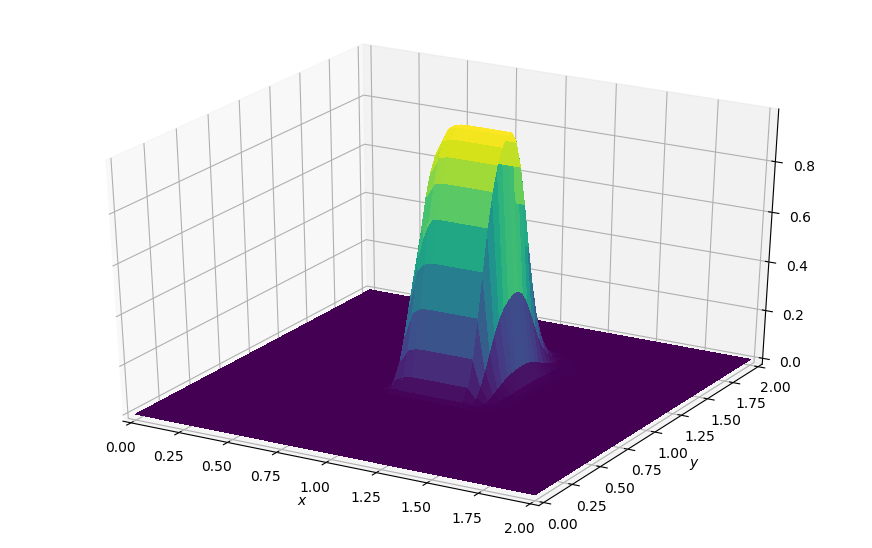

In [13]:
from devito import Operator, IterativeMethod, configuration

IterativeMethod.SOR.set_constant('omega', 1.5)

op = Operator(stencil, iterative_method = IterativeMethod.SOR)

op(time = time, dt = dt, iter_m = 1, iter_M = 10) # Run the operator

plot_field(u.data[0, :, :]) # Plot the result

The same PDE could be solved using other implicit-explicit combination of methods. For example, using Adams-Bashfort for the explicit term $B(u)$ and the trapezoidal method for the implicit term $A(u)$, the equation becomes $\frac{\partial u}{\partial t} = \frac{1}{2} (A(u(t)) + A(u(t+\Delta t)) + 3 B(u(t)) - B(u(t-\Delta t)))$.

Operator `Kernel` run in 0.00 s


Eq((0.5/h_y + 1/dt)*u(t + dt, x, y) - 0.5*u(t + dt, x, y - h_y)/h_y, -0.5*u(t, x, y)/h_y + 0.5*u(t, x, y - h_y)/h_y - 0.15*u(t, x, y)/h_x + 0.15*u(t, x - h_x, y)/h_x + 0.05*u(t - dt, x, y)/h_x - 0.05*u(t - dt, x - h_x, y)/h_x + u(t, x, y)/dt)


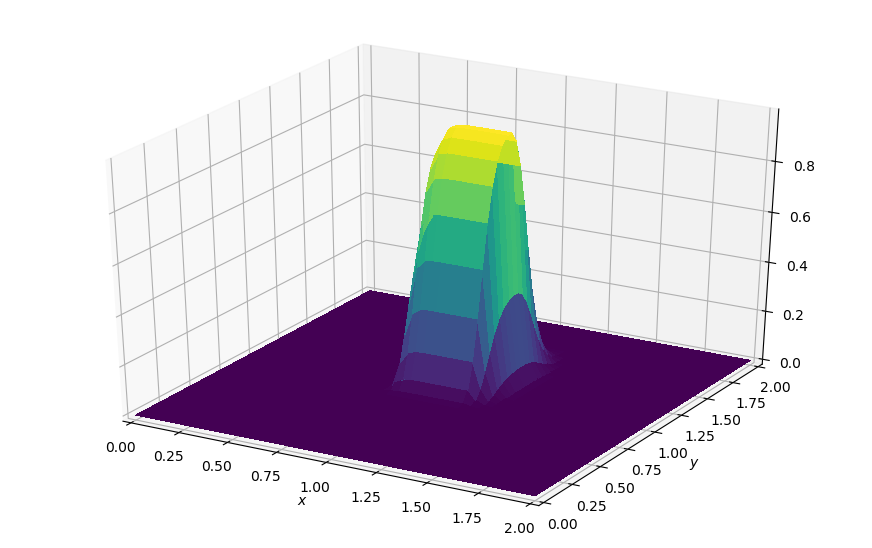

In [14]:
grid = Grid(shape = shape, extent = extent)
u = TimeFunction(name = 'u', grid = grid)

u0(u)

pde = Eq(u.dtr + 0.5*(c*(3*u.dxl - u.backward.dxl) + v*(u.dyl + u.forward.dyl)))

stencil = collect_forward(pde)

print(stencil)

op = Operator(stencil)

op(time = time, dt = dt, iter_m = 0, iter_M = 10)

plot_field(u.data[0, :, :])

Another differential equation that benefits from the use of implicit methods is the advection-diffusion equation $\frac{\partial u}{\partial t} + a ||\vec \nabla u|| = b \Delta u$, where the diffusion term $A(u) = b \Delta u$ is stiff and should be handled properly.

Eq((0.01/h_y**2 + 0.01/h_x**2 + 1/dt)*u(t + dt, x, y) - 0.005*u(t + dt, x, y - h_y)/h_y**2 - 0.005*u(t + dt, x, y + h_y)/h_y**2 - 0.005*u(t + dt, x - h_x, y)/h_x**2 - 0.005*u(t + dt, x + h_x, y)/h_x**2, -0.01*u(t, x, y)/h_y**2 + 0.005*u(t, x, y - h_y)/h_y**2 + 0.005*u(t, x, y + h_y)/h_y**2 - 0.225*u(t, x, y)/h_x - 0.075*u(t, x - 2*h_x, y)/h_x + 0.3*u(t, x - h_x, y)/h_x + 0.075*u(t - dt, x, y)/h_x + 0.025*u(t - dt, x - 2*h_x, y)/h_x - 0.1*u(t - dt, x - h_x, y)/h_x - 0.01*u(t, x, y)/h_x**2 + 0.005*u(t, x - h_x, y)/h_x**2 + 0.005*u(t, x + h_x, y)/h_x**2 + u(t, x, y)/dt)


Operator `Kernel` run in 0.01 s


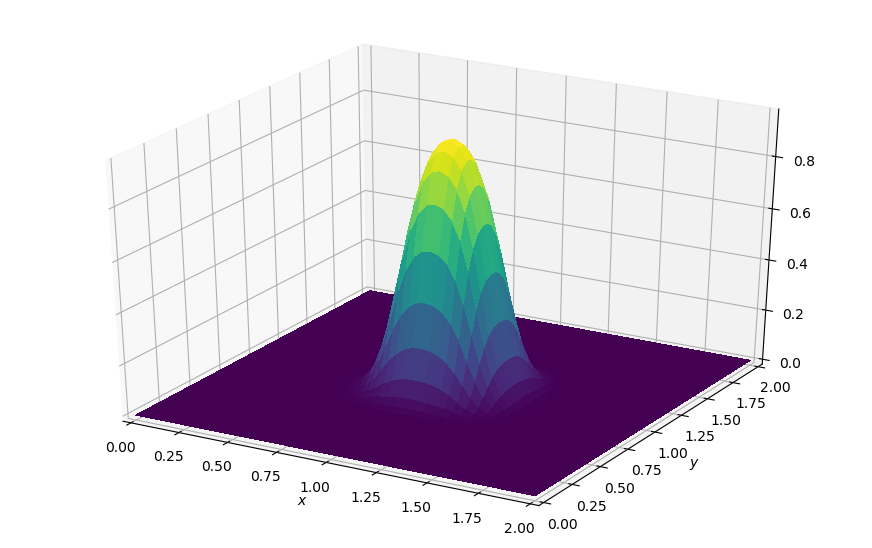

In [17]:
a, b = 0.1, 0.01        # Diffusion and advection terms, respectively

grid = Grid(shape = shape, extent = extent)
u = TimeFunction(name = 'u', grid = grid, space_order = 2) # space_order is now 2 since we calculate the laplace

u0(u)

# Forward and backward euler
# pde = Eq(u.dtr + a * u.dxl, b * u.forward.laplace)

# Adams-Bashfort (explicit) and trapezoidal (implicit)
pde = Eq(u.dtr + 0.5*(a * (3*u.dxl - u.backward.dxl) - b * (u.laplace + u.forward.laplace)))

stencil = collect_forward(pde)

print(stencil)

op = Operator(stencil)

op(time = time, dt = dt, iter_m = 0, iter_M = 10)

plot_field(u.data[0, :, :])